In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn.model_selection import train_test_split
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

/home/vezdexod/.local/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
water_data = pd.read_csv('water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — Potability (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (ph), около 24 % — о содержании сульфатов (Sulfate) и около 5 % — о тригалометанах (Trihalomethanes). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (Potability). Для этого сгруппируем данные по признаку Potability, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [5]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:

In [6]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [7]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле model_selection, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции train_test_split(). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
  
## Train shape: (2620, 9)
## Valid shape: (656, 9)

Train shape: (2620, 9)
Valid shape: (656, 9)


In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 
 
# Train hold-out accuracy: 0.82
# Valid hold-out accuracy: 0.77

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


# HOLD-OUT

Если же мы используем трёхкомпонентный подход (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), тут нам понадобится чуть больше кода. К сожалению, в sklearn нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [11]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [12]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

## Train shape: (2620, 9)
## Valid shape: (328, 9)
## Test shape: (328, 9)

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


# K-FOLD

Метод k-fold более известен как кросс-валидация (cross validation), или перекрёстный контроль.

Основные параметры инициализатора KFold:

n_split —  число фолдов (число  из метода k-fold). По умолчанию — 5.
shuffle — параметр, указывающий, стоит ли перемешивать исходный набор данных перед разбиением. По умолчанию — False.
random_state — число, на основе которого производится генерация случайных чисел, если набор данных будет перемешиваться.

In [13]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем случайный лес на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [14]:
print(train_metrics)
print(val_metrics)
 
## [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
## [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


In [15]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Конечно же, нет. На самом весь приведённый выше код можно значительно сократить, если использовать специальную функцию для кросс-валидации — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

Основные параметры функции cross_validate():

estimator — модель, качество которой будет проверяться на кросс-валидации.
X — матрица наблюдений.
y — вектор-столбец правильных ответов.
cv — кросс-валидатор из библиотеки sklearn (например, KFold) или количество фолдов, на которые необходимо разбить выборку. По умолчанию используется кросс-валидация на пяти фолдах.
scoring — название метрики в виде строки либо функция для её вычисления ('accuracy', 'precision', 'recall', 'f1' и другие; полный список — в документации к функции).
return_train_score — параметр, указывающий стоит ли возвращать значения метрики, полученных на тренировочных фолдах. По умолчанию — False, то есть метрики считаются только на валидационных фолдах.

Функция возвращает словарь со следующими ключами:

fit_time — время обучения модели на каждой итерации кросс-валидации;
score_time — время вычисления метрик на каждой итерации кросс-валидации;
test_score — значения метрик на валидационных фолдах;
train_score — значения метрик на тренировочных фолдах.

In [16]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5) # Число форлдов
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.1003809 , 0.09084964, 0.0924232 , 0.12057781, 0.11769795]),
 'score_time': array([0.00678182, 0.0091939 , 0.00938845, 0.00756717, 0.01074195]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [17]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


# LEAVE-ONE-OUT

В библиотеке sklearn метод leave-one-out реализован в классе LeaveOneOut. Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с KFold, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса LeaveOneOut также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

Примечание. Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


# Задание 3.3
Ниже представлен код для генерации задачи классификации и отрисовки диаграммы рассеяния с цветовой группировкой по классам:
Разбейте исходный набор данных на тренировочный и валидационный со стратификацией по классам в соотношении 80/20. В качестве значения параметра random_state возьмите число 42.

Постройте диаграммы рассеяния с цветовой группировкой по классам для валидационной выборки.

Из приведённых ниже диаграмм выберите ту, которая соответствует полученному разбиению:

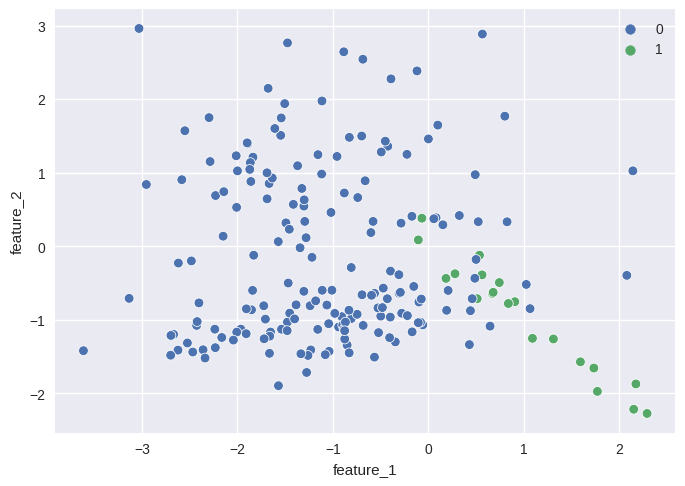

In [19]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

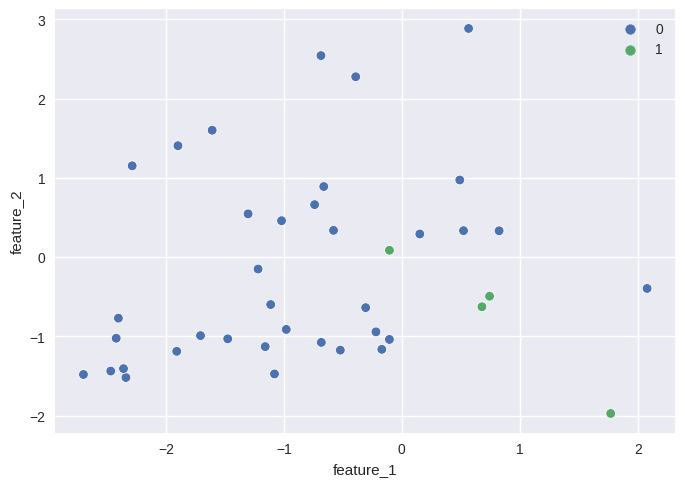

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid);    

# Задание 3.5

In [21]:
# Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42, max_iter=1000)

# Обучаем модель — ищем параметры по МНК
log_reg_full.fit(X_train, y_train)

y_pred = log_reg_full.predict(X_valid)

In [22]:
# Метрики классификации в одной строке
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        36
           1       0.50      0.25      0.33         4

    accuracy                           0.90        40
   macro avg       0.71      0.61      0.64        40
weighted avg       0.88      0.90      0.88        40



# Задание 3.7

In [23]:
# Создаём объект класса LinearRegression
log_reg_full = linear_model.LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)

# Обучаем модель — ищем параметры по МНК
log_reg_full.fit(X_train, y_train)

y_pred = log_reg_full.predict(X_valid)

In [24]:
# Метрики классификации в одной строке
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



# Задание 3.11

In [26]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

# Создаем объект класса логистическая регрессия
log_reg_full = linear_model.LogisticRegression(random_state=42)

# Обучаем модель — ищем параметры по МНК
log_reg_full.fit(X_train_s, y_train_s)

y_pred = log_reg_full.predict(X_valid)

# Метрики классификации в одной строке
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



# Задание 4.3

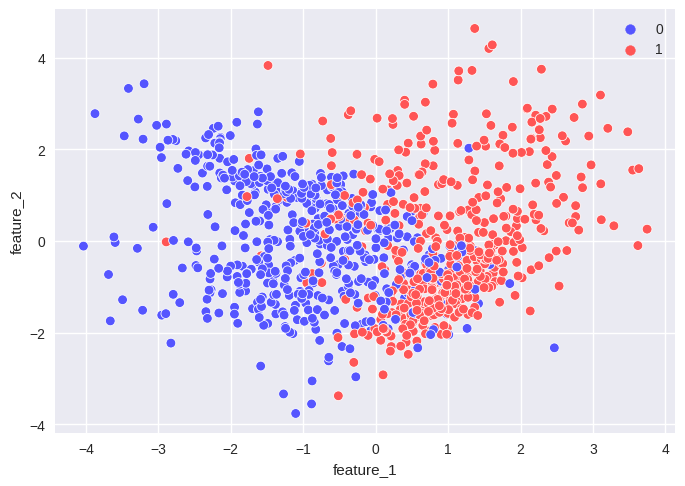

In [27]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    max_depth=10,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train accureny score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accurecy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accureny score: 0.98
Valid accurecy score: 0.83


# Задание 4.6

In [34]:
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    max_depth=3,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train accureny score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accurecy score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accureny score: 0.88
Valid accurecy score: 0.85
